In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# P-R Curve

P-R Curve (Precision-Recall Curve) 是以 Recall 為 x 軸、 Precision 為 y 軸所繪製出來的圖，會根據模型的預測結果進行排序，再按順序逐一計算 Precision、Recall。

Precision、Recall 值越高表示模型越好，因此 P-R Curve 會越往右上方靠近，使得 AUC 越大。

<img src="https://github.com/chingi071/AIoT_object_detection_tutorial/blob/main/chapter2/pictures/014.jpg?raw=true" width=400>


假設共有十個物件框，只顯示 IoU 大於 threshold 的資料，預測類別為貓咪

* ground_truth 為全部的實際框

* bndBox 為預測的 bounding box

* pred_score 為預測出的檢測框是否貓為的機率

* threshold 設定為 0.5




<img src="https://github.com/chingi071/AIoT_object_detection_tutorial/blob/main/chapter2/pictures/019.jpg?raw=true" width=500>


In [ ]:
ground_truth = np.array([1, 1, 2, 2, 3, 4, 5, 6, 5])
pred_score = np.array([0.8, 0.7, 0.2, 0.6, 0.8, 0.2, 0.9, 0.4, 0.6])

gt_len = 5
threshold = 0.5

In [ ]:
zip_list = zip(ground_truth, pred_score)
sort_zip_list = sorted(zip_list, key=lambda x:x[1], reverse=True)
zip_list = zip(*sort_zip_list)
ground_truth, pred_score = [np.array(list(x)) for x in zip_list]
print("ground_truth: ", ground_truth)
print("pred_score: ", pred_score)

pred_label = np.where(pred_score>=threshold, 1, 0)
print("pred_label: ", pred_label)

ground_truth:  [5 1 3 1 2 5 6 2 4]
pred_score:  [0.9 0.8 0.8 0.7 0.6 0.6 0.4 0.2 0.2]
pred_label:  [1 1 1 1 1 1 0 0 0]


In [ ]:
nd = len(ground_truth)
tp_list = [0] * nd
fp_list = [0] * nd
gt_idx = []
for i in range(len(ground_truth)):
  gt = ground_truth[i]
  pred = pred_label[i]

  if gt not in gt_idx:
    if pred == 1:
      tp_list[i] = 1

  else:
    fp_list[i] = 1

  gt_idx.append(gt)

print("tp_list: ", tp_list)
print("fp_list: ", fp_list)

tp_list:  [1, 1, 1, 0, 1, 0, 0, 0, 0]
fp_list:  [0, 0, 0, 1, 0, 1, 0, 1, 0]


In [ ]:
# refer; https://github.com/Cartucho/mAP/blob/3605865a350859e60c7b711838d09c4e0012c774/main.py

cumsum = 0
for idx, val in enumerate(fp_list):
    fp_list[idx] += cumsum
    cumsum += val

cumsum = 0
for idx, val in enumerate(tp_list):
    tp_list[idx] += cumsum
    cumsum += val

recall = tp_list[:]
for idx, val in enumerate(tp_list):
    recall[idx] = float(tp_list[idx]) / gt_len

precision = tp_list[:]
for idx, val in enumerate(tp_list):
    precision[idx] = float(tp_list[idx]) / (fp_list[idx] + tp_list[idx])

print("recall: ", recall)
print("precision: ", precision)

recall:  [0.2, 0.4, 0.6, 0.6, 0.8, 0.8, 0.8, 0.8, 0.8]
precision:  [1.0, 1.0, 1.0, 0.75, 0.8, 0.6666666666666666, 0.6666666666666666, 0.5714285714285714, 0.5714285714285714]


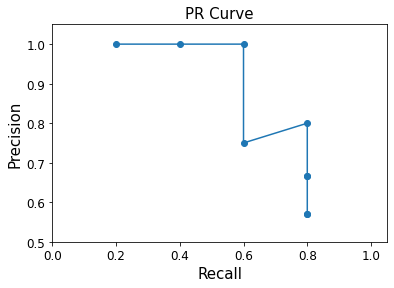

In [ ]:
plt.title('PR Curve', fontsize=15)
plt.xlabel("Recall", fontsize=15)
plt.ylabel("Precision", fontsize=15)
plt.xlim(0, 1.05)
plt.ylim(0.5, 1.05)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.scatter(recall, precision)
plt.plot(recall, precision)
plt.show()

# AP

P-R Curve 下的面積就是 AP (紫色線面積)。這邊要注意的是在計算 AP 前會先將崎嶇的線拉平 (粉紅色線)。


<img src="https://github.com/chingi071/AIoT_object_detection_tutorial/blob/main/chapter2/pictures/021.jpg?raw=true" width=400>


In [ ]:
def compute_ap(recall, precision, v5_metric=True):
    """ 
    https://github.com/WongKinYiu/yolov7/blob/55b90e111984dd85e7eed327e9ff271222aa8b82/utils/metrics.py#L81
    Compute the average precision, given the recall and precision curves
    # Arguments
        recall:    The recall curve (list)
        precision: The precision curve (list)
        v5_metric: Assume maximum recall to be 1.0, as in YOLOv5, MMDetetion etc.
    # Returns
        Average precision, precision curve, recall curve
    """

    # Append sentinel values to beginning and end
    if v5_metric:  # New YOLOv5 metric, same as MMDetection and Detectron2 repositories
        mrec = np.concatenate(([0.], recall, [1.0]))
    else:  # Old YOLOv5 metric, i.e. default YOLOv7 metric
        mrec = np.concatenate(([0.], recall, [recall[-1] + 0.01]))
    mpre = np.concatenate(([1.], precision, [0.]))

    # Compute the precision envelope
    mpre = np.flip(np.maximum.accumulate(np.flip(mpre)))

    # Integrate area under curve
    method = 'interp'  # methods: 'continuous', 'interp'
    if method == 'interp':
        x = np.linspace(0, 1, 101)  # 101-point interp (COCO)
        ap = np.trapz(np.interp(x, mrec, mpre), x)  # integrate
    else:  # 'continuous'
        i = np.where(mrec[1:] != mrec[:-1])[0]  # points where x axis (recall) changes
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])  # area under curve

    return ap, mpre, mrec

In [ ]:
ap, mpre, mrec = compute_ap(recall, precision)

In [ ]:
ap

0.815

# mAP

mAP 就是將每個類別的 AP 進行平均。

由於上述例子只有一個類別，所以另外假設其他類別的名稱及 AP，藉由這些值可以計算出 mAP


In [ ]:
class_name = ['sofa', 'bed', 'remote', 'nightstand', 'tvmonitor']
AP = [0.9, 0.86, 0.73, 0.71, 0.63]
mAP = np.sum(AP)/len(AP)

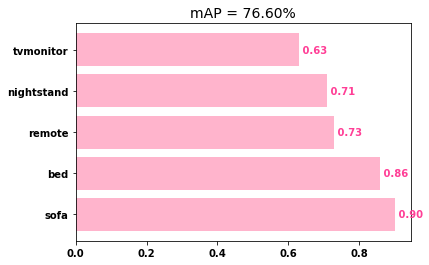

In [ ]:
plt.barh(class_name, AP, align='center', color='#FF82AB', alpha=0.6)
plot_title = "mAP = {0:.2f}%".format(mAP*100)
fig = plt.gcf() # gcf - get current figure
axes = plt.gca()
r = fig.canvas.get_renderer()
for i, val in enumerate(AP):
    str_val = " " + str(val) # add a space before
    if val < 1.0:
        str_val = " {0:.2f}".format(val)
    t = plt.text(val, i, str_val, va='center', color='#FF3E96', fontweight='bold')
plt.title(plot_title, fontsize=14)
plt.show()

# ROC Curve

ROC Curve 是以 FPR 為 x 軸、 TPR 為 y 軸所繪製出來的圖，其中 FPR (偽陽性率) 為 1- Specificity、TPR 為 Sensitivity。
當 FPR 越低 (Specificity—正確檢測出負樣本的機率越高)、TPR 越高表示模型越好，因此 ROC Curve 會越往左上方靠近，使得 AUC 越大。


<img src="https://github.com/chingi071/AIoT_object_detection_tutorial/blob/main/chapter2/pictures/016.jpg?raw=true" width=400>


使用 2.1 節所設定的二分類資料: 假設目前總共有十個值

* ground_truth 表示是否為貓 -> 是貓 (label=1)、不是貓 (label=0)

* pred_score 為預測出是否為貓的機率

In [ ]:
ground_truth = np.array([1, 1, 0, 1, 0, 0, 1, 1, 0, 0])
pred_score = np.array([0.8, 0.4, 0.1, 0.7, 0.6, 0.2, 0.9, 0.8, 0.6, 0.3])

計算 FPR、TPR

<img src="https://github.com/chingi071/AIoT_object_detection_tutorial/blob/main/chapter2/pictures/022.jpg?raw=true" width=700>

In [ ]:
zip_list = zip(ground_truth, pred_score)
sort_zip_list = sorted(zip_list, key=lambda x:x[1], reverse=True)
zip_list = zip(*sort_zip_list)
ground_truth, pred_score = [np.array(list(x)) for x in zip_list]
print("ground_truth: ", ground_truth)
print("pred_score: ", pred_score)

ground_truth:  [1 1 1 1 0 0 1 0 0 0]
pred_score:  [0.9 0.8 0.8 0.7 0.6 0.6 0.4 0.3 0.2 0.1]


In [ ]:
def cal_state_list(ground_truth, pred_label):
  nd = len(ground_truth)
  tp_list = [0] * nd
  tn_list = [0] * nd
  fn_list = [0] * nd
  fp_list = [0] * nd
  for i in range(len(ground_truth)):
    gt = ground_truth[i]
    pred = pred_label[i]

    if gt == 1 and pred == 1:
      tp_list[i] = 1

    elif gt == 1 and pred == 0:
      fn_list[i] = 1
    
    elif gt == 0 and pred == 1:
      fp_list[i] = 1

    else:
      tn_list[i] = 1

  return tp_list, tn_list, fn_list, fp_list

In [ ]:
for i in range(len(ground_truth)):
  threshold = pred_score[i]

  pred_label = np.where(pred_score>=threshold, 1, 0)
  tp_list, tn_list, fn_list, fp_list = cal_state_list(ground_truth, pred_label)

  tp_len = np.sum(tp_list)
  tn_len = np.sum(tn_list)
  fn_len = np.sum(fn_list)
  fp_len = np.sum(fp_list)

  cumsum = 0
  for idx, val in enumerate(fp_list):
      fp_list[idx] += cumsum
      cumsum += val

  cumsum = 0
  for idx, val in enumerate(tp_list):
      tp_list[idx] += cumsum
      cumsum += val

  tpr = tp_list[:]
  for idx, val in enumerate(tp_list):
      tpr[idx] = float(tp_list[idx]) / (tp_len + fn_len)

  fpr = fp_list[:]
  for idx, val in enumerate(fp_list):
      fpr[idx] = float(fp_list[idx]) / (tn_len + fp_len)

print("TPR: ", tpr)
print("FPR: ", fpr)

TPR:  [0.2, 0.4, 0.6, 0.8, 0.8, 0.8, 1.0, 1.0, 1.0, 1.0]
FPR:  [0.0, 0.0, 0.0, 0.0, 0.2, 0.4, 0.4, 0.6, 0.8, 1.0]


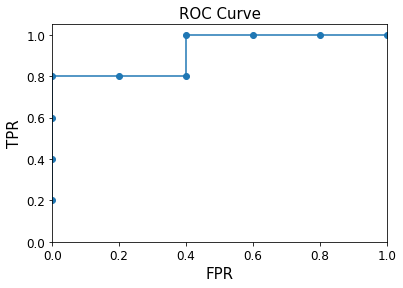

In [ ]:
plt.title('ROC Curve', fontsize=15)
plt.xlabel("FPR", fontsize=15)
plt.ylabel("TPR", fontsize=15)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.scatter(fpr, tpr)
plt.plot(fpr, tpr)
plt.show()

可以藉由 sklearn 計算 ROC Curve，參考：https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html

Text(0.5, 0, 'False Positive Rate')

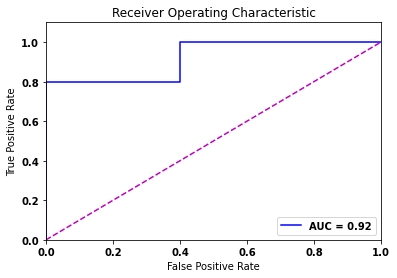

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(ground_truth, pred_score)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'blue', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'m--')
plt.xlim([0,1])
plt.ylim([0,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')